In [ ]:
import cv2
import dlib
import numpy as np
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image 
import matplotlib.pyplot as plt
import os
import math

In [ ]:
from zipfile import ZipFile
file_name = "dataset.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
path_lists = []
matrix_lists = []
for folder_name in os.listdir('/content/dataset'):
  path_1 = os.path.join('/content/dataset', folder_name)
  for file_name in os.listdir(path_1):
    path_2 = os.path.join(path_1, file_name)
    if os.path.isfile(path_2):
      path_lists.append(path_2)
      image = cv2.imread(path_2)
      matrix_lists.append(image)
print(path_lists)

['/content/dataset/1/KL.FE1.174.jpg', '/content/dataset/1/MK.NE2.114.jpg', '/content/dataset/1/KA.SU3.38.jpg', '/content/dataset/1/KR.SA2.78.jpg', '/content/dataset/1/KA.SU1.36.jpg', '/content/dataset/1/NM.AN3.106.jpg', '/content/dataset/1/NA.NE1.199.jpg', '/content/dataset/1/KR.SU2.81.jpg', '/content/dataset/1/UY.HA3.139.jpg', '/content/dataset/1/NA.DI2.215.jpg', '/content/dataset/1/NA.NE3.201.jpg', '/content/dataset/1/KL.SU1.164.jpg', '/content/dataset/1/NA.DI3.216.jpg', '/content/dataset/1/YM.FE1.67.jpg', '/content/dataset/1/NM.FE2.111.jpg', '/content/dataset/1/KR.SU3.82.jpg', '/content/dataset/1/KA.HA2.30.jpg', '/content/dataset/1/KA.HA3.31.jpg', '/content/dataset/1/NM.SA3.100.jpg', '/content/dataset/1/MK.HA1.116.jpg', '/content/dataset/1/KL.AN3.169.jpg', '/content/dataset/1/KL.SA2.162.jpg', '/content/dataset/1/KA.AN1.39.jpg', '/content/dataset/1/TM.HA2.181.jpg', '/content/dataset/1/KR.SA2.78_1.jpg', '/content/dataset/1/NM.FE3.112.jpg', '/content/dataset/1/KA.SA2.34.jpg', '/content

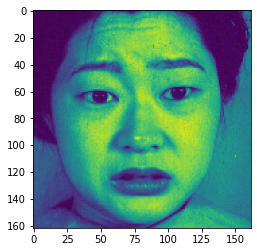

In [ ]:
#face_cropping
gray_list=[]
cropped_img_list=[]
for img in matrix_lists:
  face_cascade=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  gray_list.append(gray)
  faces=face_cascade.detectMultiScale(gray,1.3,5,minSize=(100,100))
  face_x, face_y, face_w, face_h = faces[0]
  cropped_img= gray[int(face_y):int(face_y+face_h), int(face_x):int(face_x+face_w)]
  cropped_img_list.append(cropped_img)
plt.imshow(cropped_img_list[0])
    


In [ ]:
#face_allignment
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bunzip2 "shape_predictor_5_face_landmarks.dat.bz2"

--2020-06-17 11:39:22--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M  2.95MB/s    in 1.8s    

2020-06-17 11:39:24 (2.95 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2’ saved [5706710/5706710]



In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')
print(predictor)

In [ ]:
def euclidean_distance(a, b):
  x1 = a[0]; y1 = a[1]
  x2 = b[0]; y2 = b[1]
  return math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))

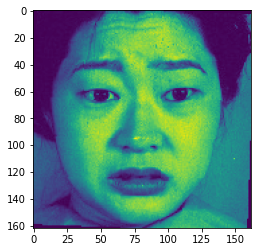

In [ ]:
raw_img_list=[]
rotated_img_list=[]
for img in cropped_img_list:
  raw_img=img.copy()
  rects = detector(raw_img, 0)
  if len(rects) > 0:
    for rect in rects:
        x = rect.left()
        y = rect.top()
        w = rect.right()
        h = rect.bottom()
    landmarks = predictor(raw_img, rect)
    left_eye_left_x,left_eye_left_y,left_eye_right_x,left_eye_right_y=landmarks.part(2).x,landmarks.part(2).y,landmarks.part(3).x,landmarks.part(3).y
    right_eye_left_x,right_eye_left_y,right_eye_right_x,right_eye_right_y=landmarks.part(1).x,landmarks.part(1).y,landmarks.part(0).x,landmarks.part(0).y
    left_eye_center =((left_eye_left_x+left_eye_right_x)//2,(left_eye_left_y+left_eye_right_y)//2)
    right_eye_center =((right_eye_left_x+right_eye_right_x)//2,(right_eye_left_y+right_eye_right_y)//2)
    left_eye_x = left_eye_center[0]; left_eye_y = left_eye_center[1]
    right_eye_x = right_eye_center[0]; right_eye_y = right_eye_center[1]

    

    if left_eye_y < right_eye_y:
      point_3rd = (right_eye_x, left_eye_y)
      direction = 1 
      #rotate same direction to clock
    else:
      point_3rd = (left_eye_x, right_eye_y)
      direction = -1 #rotate inverse direction of clock

    a = euclidean_distance(left_eye_center, point_3rd)
    b = euclidean_distance(right_eye_center, left_eye_center)
    c = euclidean_distance(right_eye_center, point_3rd) 
    
    cos_a = (b*b + c*c - a*a)/(2*b*c) 
    angle = np.arccos(cos_a)
    angle = (angle * 180) / math.pi
    if direction == 1:
      angle = 90 - angle
    
    rotated_img = Image.fromarray(raw_img)


    
    rotated_img = np.array(rotated_img.rotate(direction * angle))
    rotated_img_list.append(rotated_img)
 
    

plt.imshow(rotated_img_list[0])

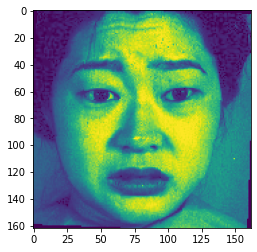

In [ ]:
#histogram_equilization
histogram_list=[]
for img in rotated_img_list:
  equ = cv2.equalizeHist(img)
  histogram_list.append(equ)
plt.imshow(histogram_list[0])

In [ ]:
#data_augmentation
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

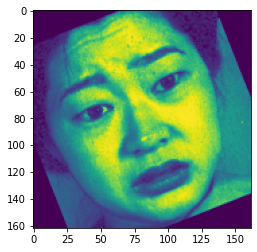

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 
random_rotation_list=[]
for img in histogram_list:
  random_img=random_rotation(img)
  random_rotation_list.append(random_img)
plt.imshow(random_rotation_list[0])


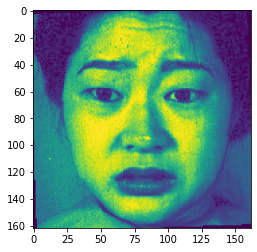

In [ ]:
flip_list=[]
for img in histogram_list:
  flipped_img=horizontal_flip(img)
  flip_list.append(flipped_img)
plt.imshow(flip_list[0])

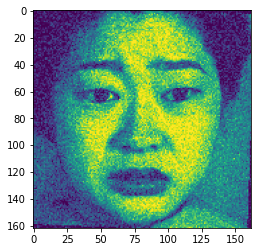

In [ ]:
noise_list=[]
for img in histogram_list:
  noise_image=random_noise(img)
  noise_list.append(noise_image)
plt.imshow(noise_list[0]) 

In [ ]:
final_list=[]
for img in histogram_list:
  final_list.append(img)


In [ ]:

for img in random_rotation_list:
  final_list.append(img)


In [ ]:
for img in flip_list:
  final_list.append(img)

In [ ]:
for img in noise_list:
  final_list.append(img)

In [ ]:
print(len(final_list))

876
